# Linear agent, no obstacles, trajectory following

## The agent

First we load a demo agent:

In [3]:
N = 10;     % prediction horizon
Ts = 0.25;  % sampling time
agent = moantool.LinearAgent.demo2D('PredictionHorizon', N, 'SamplingTime', Ts)

agent = 

  LinearAgent with properties:

                 A: [4x4x10 moantool.AgentSignal]
                 B: [4x2x10 moantool.AgentSignal]
                 f: [4x1x10 moantool.AgentSignal]
                 C: [2x4x10 moantool.AgentSignal]
                 D: [2x2x10 moantool.AgentSignal]
                 g: [2x1x10 moantool.AgentSignal]
                nx: 4
                nu: 2
                ny: 2
                 N: 10
                 X: [4x1x11 moantool.AgentSignal]
                 U: [2x1x10 moantool.AgentSignal]
                 Y: [2x1x10 moantool.AgentSignal]
              Size: [2x1x10 moantool.AgentSignal]
    ConstraintsFun: []
      ObjectiveFun: []


Tell the agent that the position reference should be treated as a time-varying parameter:

In [4]:
agent.Y.Reference = 'parameter';

Since we will be plotting the agent as a planar object, we set its width and height to one:

In [5]:
agent.Size.Value = [1; 1];

## The planner

Next, we create a planner which will be responsible for optimizing the control inputs for the agent:

In [6]:
obstacles = []; % no obstacles in this demo
planner = moantool.Planner(agent, obstacles, 'solver', 'gurobi')

planner = 

  Planner with properties:

      Parameters: [1x1 struct]
    MixedInteger: 1


To obtain optimal control inputs for the current state $x(k)$, call the `planner.optimize(x)` method.

In [7]:
x = [0; 10; 0; -10];
u = planner.optimize(x)

There are missing values.


An error! It tells us that in the agent we have proclaimed some variables as time-varying parameters, but didn't specify their values at the time the optimization problem is solved. Let's see what we have forgot to set:

In [8]:
planner.listMissing()

planner.Parameters.Agent.Y.Reference  [2 1 10]


Ok, we need to provide the value of the output reference by setting `planner.Parameters.Agent.Y.Reference` to some value. It can either be a 2x1 vector, or a 2x10 matrix. In the former case the value is expanded over the whole prediction horizon. In the latter case, each column of the matrix is treated as the reference for the k-th step of the prediction horizon.

Therefore

In [9]:
planner.Parameters.Agent.Y.Reference = [3; 5];

would set the output reference to be constantly [3; 5] for the whole prediction horizon. (Remember, this only applies to the current optimization. The next time we solve the problem again, we can choose a different value).

If instead we use

In [10]:
planner.Parameters.Agent.Y.Reference = [1:10; 10:-1:1];

then we set $y_{\text{ref}}(0) = [1; 10]$, $y_{\text{ref}}(1) = [2; 9]$ and so on.

Now that we have provided the value of the parameters, the `optimize()` method should complain no more:

In [11]:
u = planner.optimize(x)

[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 

u =

   -2.0000
    2.0000


We have obtained the value of the optimal control input as the first element of the optimized open-loop sequence. You can request more information from the `optimize()` method:

In [12]:
[u, problem, openloop] = planner.optimize(x)

[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 

u =

   -2.0000
    2.0000


problem =

     0


openloop = 

    X: [4x11 double]
    U: [2x10 double]
    Y: [2x10 double]


The `problem` output indicates whether the optimization was feasible. In short, `problem=0` is returned when no problems were detected. Any non-zero value indicates some issues. Use `yalmiperror(problem)` to see the meaning of the error code:

In [13]:
yalmiperror(problem)

ans =

Successfully solved


The `openloop` output contains optimized predicted trajectories of states, inputs, and outputs:

## Closed-loop simulation (manual approach)

Let's build a simple closed-loop simulation manually:

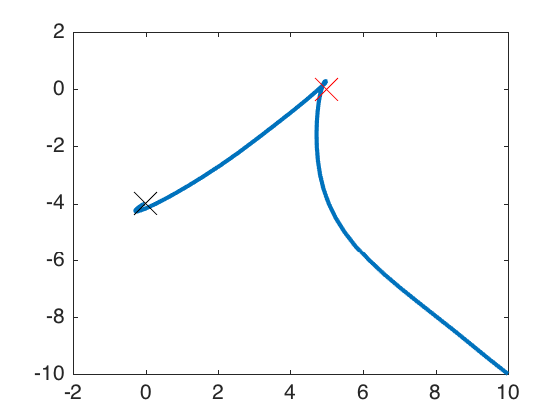

[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  

In [14]:
x0 = [0; 10; 0; -10]; % initial position [10; -10] with zero speed in both axis
Nsim = 60; % number of simulation steps

% load sample dynamics of the plant
simdata = moantool.LinearAgent.demo2Ddata(Ts);

% storage for closed-loop profiles of states, inputs and outputs
X = x0;
U = [];
Y = [];
% simulation loop
for k = 1:Nsim
    % the reference will be [5; 0] for the first half of the simulation and [0; -4] for the second half
    if k<=Nsim/2
        planner.Parameters.Agent.Y.Reference = [5; 0];
    else
        planner.Parameters.Agent.Y.Reference = [0; -4];
    end
    x = X(:, end); % last known state
    [u, prob] = planner.optimize(x);
    if prob~=0
        error('Problem at step %d: %s', k, yalmiperror(prob));
    end
    % state update
    xn = simdata.A*x+simdata.B*u;
    y = simdata.C*x;
    X = [X, xn];
    Y = [Y, y];
    U = [U, u];
end

% plot the closed-loop profiles in the x-y plane
plot(Y(1, :), Y(2, :), 'linewidth', 2);
hold on
plot(5, 0, 'rx', 'markersize', 15); % first reference
plot(0, -4, 'kx', 'markersize', 15); % second reference

## Closed-loop simulation via Simulator

A more convenient approach to closed-loop simulations is to use the dedicated `Simulator` class:

In [15]:
psim = moantool.Simulator(planner)

psim = 

  Simulator with properties:

       Results: [1x1 struct]
    Parameters: [1x1 struct]


Any time-varying parameters (references, dynamics, constraints, etc.) can be set via `psim.Parameters`. The procedure is identical to setting the values via a planner. For example, to set the position reference to `[5; 0]` for the first half of the simulation, and to `[0; -4]` for the second half, do

In [16]:
Nsim = 60;
yref = [repmat([5; 0], 1, Nsim/2), repmat([0; -4], 1, Nsim/2)];
psim.Parameters.Agent.Y.Reference = yref;

As we can see, the simulation horizon given by `Nsim` is split into $n_w$ parts (where $n_w$ is the number of waypoints), with $w_1$ used in the first part, $w_2$ in the second one, etc.

Back to the simulator, though. Once the parameters are set, we can run the simulation by invoking the `run` method, providing the initial state `x0` and the number of simulation steps `Nsim`:

In [17]:
x0 = [0; 10; 0; -10];
psim.run(x0, Nsim);

[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In moantool.Simulator/run (line 270)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In moantool.Simulator/run (line 270)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In moantool.Simulator/run (line 270)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In moantool.Simulator/run (line 270)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 


After the simulation completes, the closed-loop profiles of states, inputs and outputs can be found in `psim.Results`:

In [18]:
psim.Results

ans = 

                  X: [4x61 double]
                  U: [2x60 double]
                  Y: [2x60 double]
        Predictions: [1x60 struct]
    ConsPredictions: [1x1 struct]
               Nsim: 60


To visualize recorded profiles, use the `psim.plot` method:

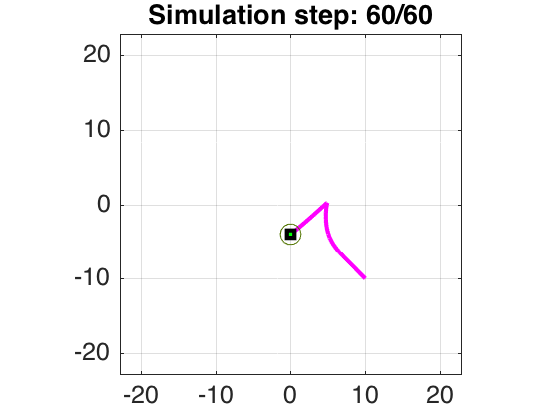

In [22]:
psim.plot('Trail', true)

## Complete code

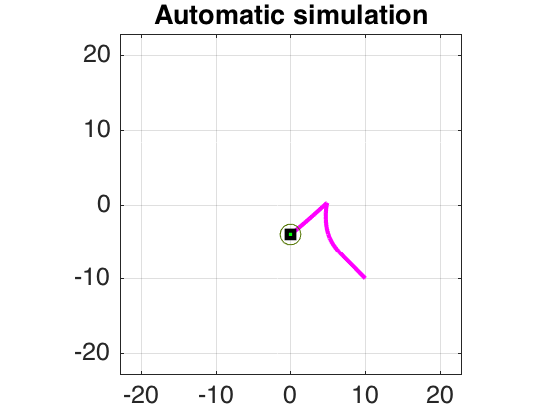

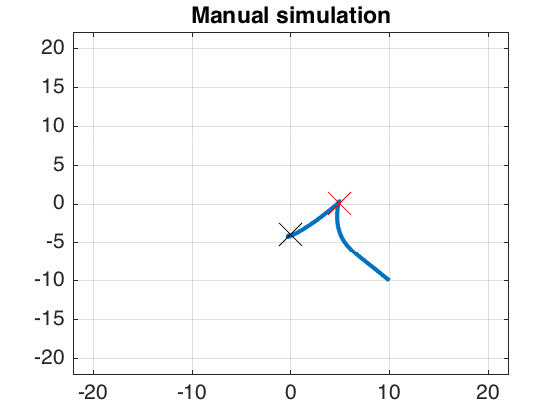

[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Unknown parameter: 'PreMIQPMethod'
] 
[> In callgurobi (line 13)
  In optimizer/subsref (line 159)
  In moantool.Planner/optimize (line 245)
  

In [20]:
clear
close all

%% setup
N = 10;     % prediction horizon
Ts = 0.25;  % sampling time
agent = moantool.LinearAgent.demo2D('PredictionHorizon', N, 'SamplingTime', Ts);
agent.Size.Value = [1; 1]; % width and length of the agent
% the reference will be provided during the simulation
agent.Y.Reference = 'parameter';
obstacles = []; % no obstacles in this demo
planner = moantool.Planner(agent, obstacles, 'solver', 'gurobi');

%% manual closed-loop simulation
x0 = [0; 10; 0; -10]; % initial position [10; -10] with zero speed in both axis
Nsim = 60; % number of simulation steps

% load sample dynamics of the plant
simdata = moantool.LinearAgent.demo2Ddata(Ts);

% storage for closed-loop profiles of states, inputs and outputs
X = x0;
U = [];
Y = [];

% the reference will be [5; 0] for the first half of the simulation and 
% [0; -4] for the second half 
yref1 = [5; 0];
yref2 = [0; -4];

% simulation loop
for k = 1:Nsim
    if k<=Nsim/2
        planner.Parameters.Agent.Y.Reference = yref1;
    else
        planner.Parameters.Agent.Y.Reference = yref2;
    end
    x = X(:, end); % last known state
    [u, prob] = planner.optimize(x);
    if prob~=0
        error('Problem at step %d: %s', k, yalmiperror(prob));
    end
    % state update
    xn = simdata.A*x+simdata.B*u;
    y = simdata.C*x;
    X = [X, xn];
    Y = [Y, y];
    U = [U, u];
end
% plot the closed-loop profiles in the x-y plane
plot(Y(1, :), Y(2, :), 'linewidth', 2);
hold on
plot(5, 0, 'rx', 'markersize', 15); % first reference
plot(0, -4, 'kx', 'markersize', 15); % second reference
axis([-22 22 -22 22]); grid on
title('Manual simulation')
drawnow

%% automatic closed-loop simulation
psim = moantool.Simulator(planner);
psim.Parameters.Agent.Y.Reference = psim.pointwiseTrajectory(Nsim+10, [yref1, yref2]);
psim.run(x0, Nsim);
psim.plot('Trail', true);
title('Automatic simulation')

## Notes & hints

**Hint**: use the `Simulator/pointwiseTrajectory` helper to automatically create a trajectory over `Nsim` steps which follows specified waypoints:

In [21]:
w1 = [5; 0]; w2 = [0; -4]; w3 = [1; 1]; M = 24;
w = psim.pointwiseTrajectory(M, [w1 w2 w3])

w =

  Columns 1 through 13

     5     5     5     5     5     5     5     5     0     0     0     0     0
     0     0     0     0     0     0     0     0    -4    -4    -4    -4    -4

  Columns 14 through 25

     0     0     0     1     1     1     1     1     1     1     1     1
    -4    -4    -4     1     1     1     1     1     1     1     1     1
